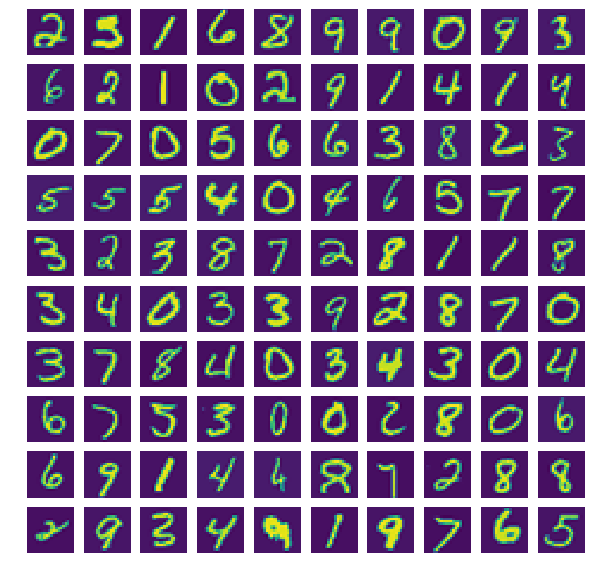

In [28]:
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import pandas as pd

data = loadmat('E:\Mat_Work\machine-learning-ex4\ex4\ex4data1.mat')
X = data['X']
y = data['y']

_, axarr = plt.subplots(10,10,figsize=(10,10))
for i in range(10):
    for j in range(10):
        axarr[i,j].imshow(X[np.random.randint(X.shape[0])].reshape((20,20), order = 'F'))          
        axarr[i,j].axis('off')

In [29]:
weights = loadmat('E:\Mat_Work\machine-learning-ex4\ex4\ex4weights.mat')
theta1 = weights['Theta1']
theta2 = weights['Theta2']

nn_params = np.hstack((theta1.ravel(order='F'),theta2.ravel(order='F')))

input_layer_size = 400
hidden_layer_size = 25
num_labels = 10
lmbda = 1

In [30]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

In [31]:
def nnCostFunc(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lmbda):
    theta1 = np.reshape(nn_params[:hidden_layer_size*(input_layer_size+1)], (hidden_layer_size, input_layer_size+1), 'F')
    theta2 = np.reshape(nn_params[hidden_layer_size*(input_layer_size+1):], (num_labels, hidden_layer_size+1), 'F')

    m = len(y)
    ones = np.ones((m,1))
    a1 = np.hstack((ones, X))
    a2 = sigmoid(a1 @ theta1.T)
    a2 = np.hstack((ones, a2))
    h = sigmoid(a2 @ theta2.T)
    
    y_d = pd.get_dummies(y.flatten())
    
    temp1 = np.multiply(y_d, np.log(h))
    temp2 = np.multiply(1-y_d, np.log(1-h))
    temp3 = np.sum(temp1 + temp2)
    
    sum1 = np.sum(np.sum(np.power(theta1[:,1:],2), axis = 1))
    sum2 = np.sum(np.sum(np.power(theta2[:,1:],2), axis = 1))
    
    return np.sum(temp3 / (-m)) + (sum1 + sum2) * lmbda / (2*m)

In [32]:
nnCostFunc(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lmbda)

0.38376985909092354

In [34]:
def sigmoidGrad(z):
    return np.multiply(sigmoid(z), 1-sigmoid(z))

In [35]:
def randInitializeWeights(L_in, L_out):
    epsilon = 0.12
    return np.random.rand(L_out, L_in+1) * 2 * epsilon - epsilon

initial_theta1 = randInitializeWeights(input_layer_size, hidden_layer_size)
initial_theta2 = randInitializeWeights(hidden_layer_size, num_labels)

# unrolling parameters into a single column vector
nn_initial_params = np.hstack((initial_theta1.ravel(order='F'), initial_theta2.ravel(order='F')))

In [36]:
def nnGrad(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lmbda):
    
    initial_theta1 = np.reshape(nn_params[:hidden_layer_size*(input_layer_size+1)], (hidden_layer_size, input_layer_size+1), 'F')
    initial_theta2 = np.reshape(nn_params[hidden_layer_size*(input_layer_size+1):], (num_labels, hidden_layer_size+1), 'F')
    y_d = pd.get_dummies(y.flatten())
    delta1 = np.zeros(initial_theta1.shape)
    delta2 = np.zeros(initial_theta2.shape)
    m = len(y)
    
    for i in range(X.shape[0]):
        ones = np.ones(1)
        a1 = np.hstack((ones, X[i]))
        z2 = a1 @ initial_theta1.T
        a2 = np.hstack((ones, sigmoid(z2)))
        z3 = a2 @ initial_theta2.T
        a3 = sigmoid(z3)

        d3 = a3 - y_d.iloc[i,:][np.newaxis,:]
        z2 = np.hstack((ones, z2))
        d2 = np.multiply(initial_theta2.T @ d3.T, sigmoidGrad(z2).T[:,np.newaxis])
        delta1 = delta1 + d2[1:,:] @ a1[np.newaxis,:]
        delta2 = delta2 + d3.T @ a2[np.newaxis,:]
        
    delta1 /= m
    delta2 /= m
    #print(delta1.shape, delta2.shape)
    delta1[:,1:] = delta1[:,1:] + initial_theta1[:,1:] * lmbda / m
    delta2[:,1:] = delta2[:,1:] + initial_theta2[:,1:] * lmbda / m
        
    return np.hstack((delta1.ravel(order='F'), delta2.ravel(order='F')))

In [37]:
nn_backprop_Params = nnGrad(nn_initial_params, input_layer_size, hidden_layer_size, num_labels, X, y, lmbda)

In [39]:
def checkGradient(nn_initial_params,nn_backprop_Params,input_layer_size, hidden_layer_size, num_labels,myX,myy,mylambda=0.):
    myeps = 0.0001
    flattened = nn_initial_params
    flattenedDs = nn_backprop_Params
    n_elems = len(flattened) 
    #Pick ten random elements, compute numerical gradient, compare to respective D's
    for i in range(10):
        x = int(np.random.rand()*n_elems)
        epsvec = np.zeros((n_elems,1))
        epsvec[x] = myeps

        cost_high = nnCostFunc(flattened + epsvec.flatten(),input_layer_size, hidden_layer_size, num_labels,myX,myy,mylambda)
        cost_low  = nnCostFunc(flattened - epsvec.flatten(),input_layer_size, hidden_layer_size, num_labels,myX,myy,mylambda)
        mygrad = (cost_high - cost_low) / float(2*myeps)
        print("Element: {0}. Numerical Gradient = {1:.9f}. BackProp Gradient = {2:.9f}.".format(x,mygrad,flattenedDs[x]))


In [40]:
checkGradient(nn_initial_params,nn_backprop_Params,input_layer_size, hidden_layer_size, num_labels,X,y,lmbda)

Element: 5422. Numerical Gradient = -0.016247791. BackProp Gradient = -0.016247791.
Element: 6931. Numerical Gradient = -0.002404611. BackProp Gradient = -0.002404611.
Element: 875. Numerical Gradient = -0.000023503. BackProp Gradient = -0.000023503.
Element: 501. Numerical Gradient = -0.000023745. BackProp Gradient = -0.000023745.
Element: 9171. Numerical Gradient = 0.000163087. BackProp Gradient = 0.000163087.
Element: 9695. Numerical Gradient = 0.000005813. BackProp Gradient = 0.000005813.
Element: 179. Numerical Gradient = -0.000013095. BackProp Gradient = -0.000013095.
Element: 3479. Numerical Gradient = 0.000735013. BackProp Gradient = 0.000735013.
Element: 1391. Numerical Gradient = -0.000073076. BackProp Gradient = -0.000073076.
Element: 3561. Numerical Gradient = -0.000017056. BackProp Gradient = -0.000017056.


In [41]:
theta_opt = opt.fmin_cg(maxiter = 50, f = nnCostFunc, x0 = nn_initial_params, fprime = nnGrad,args = (input_layer_size, hidden_layer_size, num_labels, X, y.flatten(), lmbda))

theta1_opt = np.reshape(theta_opt[:hidden_layer_size*(input_layer_size+1)], (hidden_layer_size, input_layer_size+1), 'F')
theta2_opt = np.reshape(theta_opt[hidden_layer_size*(input_layer_size+1):], (num_labels, hidden_layer_size+1), 'F')

         Current function value: 0.436013
         Iterations: 50
         Function evaluations: 109
         Gradient evaluations: 109


In [42]:
def predict(theta1, theta2, X, y):
    m = len(y)
    ones = np.ones((m,1))
    a1 = np.hstack((ones, X))
    a2 = sigmoid(a1 @ theta1.T)
    a2 = np.hstack((ones, a2))
    h = sigmoid(a2 @ theta2.T)
    return np.argmax(h,axis=1)+1
    

In [43]:
pred = predict(theta1_opt, theta2_opt, X, y)
np.mean(pred == y.flatten()) * 100

96.22